In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Skin-classification')

In [4]:
import os
import random
import requests
import time
import ast
import numpy as np
from glob import glob
import cv2                
from PIL import Image, ImageFile 
import time
from collections import OrderedDict 
import csv
import pandas as pd
import sys
import itertools
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import torchvision.models as models

import time

import matplotlib.pyplot as plt                        
%matplotlib inline

ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()

#pip install torchsummary
from torchsummary import summary

import Helper

# Explore data

In [5]:
train_dir = ["/content/drive/MyDrive/Skin-classification/data/train/melanoma", 
               "/content/drive/MyDrive/Skin-classification/data/train/nevus",
               "/content/drive/MyDrive/Skin-classification/data/train/seborrheic_keratosis"]

test_dir = ["/content/drive/MyDrive/Skin-classification/data/test/melanoma", 
              "/content/drive/MyDrive/Skin-classification/data/test/nevus",
              "/content/drive/MyDrive/Skin-classification/data/test/seborrheic_keratosis"]

def get_images_paths(directory, n_per_class):
  img_paths = []
  for i in range(3):
    cont = 1
    for file in glob(directory[i]+"/*.jpg"):
      img_paths.append(file)
      if cont == n_per_class:
        break
      cont +=1 
  return img_paths

# Get a sample of 15 training images (5 for each class)
img_paths = get_images_paths(train_dir, 5)
print(len(img_paths))
print(img_paths)


15
['/content/drive/MyDrive/Skin-classification/data/train/melanoma/ISIC_0000002.jpg', '/content/drive/MyDrive/Skin-classification/data/train/melanoma/ISIC_0000004.jpg', '/content/drive/MyDrive/Skin-classification/data/train/melanoma/ISIC_0000013.jpg', '/content/drive/MyDrive/Skin-classification/data/train/melanoma/ISIC_0000022.jpg', '/content/drive/MyDrive/Skin-classification/data/train/melanoma/ISIC_0000026.jpg', '/content/drive/MyDrive/Skin-classification/data/train/nevus/ISIC_0000000.jpg', '/content/drive/MyDrive/Skin-classification/data/train/nevus/ISIC_0000001.jpg', '/content/drive/MyDrive/Skin-classification/data/train/nevus/ISIC_0000003.jpg', '/content/drive/MyDrive/Skin-classification/data/train/nevus/ISIC_0000006.jpg', '/content/drive/MyDrive/Skin-classification/data/train/nevus/ISIC_0000007.jpg', '/content/drive/MyDrive/Skin-classification/data/train/seborrheic_keratosis/ISIC_0012103.jpg', '/content/drive/MyDrive/Skin-classification/data/train/seborrheic_keratosis/ISIC_00121

# Image vizualization

In [6]:
images = []
for path in img_paths: 
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  images.append(image)

# Check if images has the same shape
for i in range(len(images)):
  print("image: ", i, " has shape: ", images[i].shape)

image:  0  has shape:  (767, 1022, 3)
image:  1  has shape:  (767, 1022, 3)
image:  2  has shape:  (767, 1022, 3)
image:  3  has shape:  (1129, 1504, 3)
image:  4  has shape:  (1129, 1504, 3)
image:  5  has shape:  (767, 1022, 3)
image:  6  has shape:  (767, 1022, 3)
image:  7  has shape:  (767, 1022, 3)
image:  8  has shape:  (767, 1022, 3)
image:  9  has shape:  (767, 1022, 3)
image:  10  has shape:  (2000, 3008, 3)
image:  11  has shape:  (2000, 3008, 3)
image:  12  has shape:  (2000, 3008, 3)
image:  13  has shape:  (2000, 3008, 3)
image:  14  has shape:  (2848, 4288, 3)


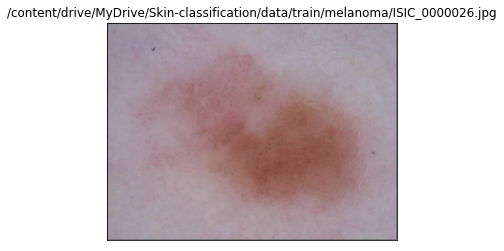

In [7]:
# Visualize images
index = 4

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title(img_paths[index])
ax1.imshow(images[index])

Check model architecture for transfer learning

In [8]:
model = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


## Load data

In [11]:
root_path = "/content/drive/MyDrive/Skin-classification/data/"

# With data augmentation
train_transforms = transforms.Compose([transforms.Resize((350,350)),
                                       transforms.CenterCrop(299),
                                       transforms.RandomRotation(0, 359),
                                       transforms.RandomVerticalFlip(0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((300,300)),
                                       transforms.CenterCrop(299),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = valid_transforms

train_data = datasets.ImageFolder(root_path+'train', transform=train_transforms)
valid_data = datasets.ImageFolder(root_path+'vaild', transform=valid_transforms)
test_data = datasets.ImageFolder(root_path+'test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

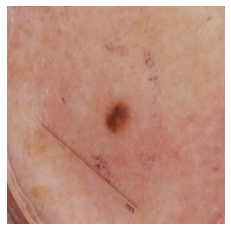

In [12]:
# Visualize different training images
import numpy as np 

def imshow(image, ax=None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
    fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))
  
  if normalize:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')
  return ax

images, labels = next(iter(trainloader))
imshow(images[7])

## Build model



In [13]:
for parameters in model.parameters():
  parameters.requires_grad = False

Create the classifier

In [14]:
BasicConv2d = nn.Sequential(OrderedDict([('conv', nn.Conv2d(2048, 192, kernel_size=(1,1), stride=(1,1))),
                                         ('bn', nn.BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True))]))

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 512)),
                                         ('relu', nn.ReLU()),
                                         ('drop', nn.Dropout(0.5)),
                                         ('fc2', nn.Linear(512, 3)), 
                                         ('output', nn.Softmax(dim=1))]))

model.Mixed_7c.branch_pool = BasicConv2d
model.fc = classifier

## Train classifier
### check for GPU

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Accuracy before training

In [16]:
def accuracy(validloader):    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) 
            outputs, aux = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network %d %%' % (100 * correct / total))

model.to(device)
accuracy(validloader)

Accuracy of the network 20 %


Check how much time will take on a simple batch

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.fc.parameters(), lr=0.001)

model.to(device)
model.train()

inputs, labels = next(iter(trainloader))
inputs, labels = inputs.to(device), labels.to(device)

start = time.time()

outputs = model.forward(inputs)
# Inception has multiple outputs
loss = sum((criterion(out, labels) for out in outputs))
loss.backward()
optimizer.step()

print(f"Device = GPU; Time per batch: {(time.time() - start):.3f} seconds")

Device = GPU; Time per batch: 10.786 seconds


Train classifier

In [18]:
def validation(model, validloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in validloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model.forward(images)
      test_loss += criterion(outputs, labels).item()
      ps = torch.exp(outputs)
      equality = (labels.data == ps.max(dim=1)[1])
      accuracy += equality.type(torch.FloatTensor).mean()
    return test_loss, accuracy
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, momentum=0, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model.to(device)

running_loss = 0
step = 0
print_every = 1
epochs = 5


model.train()
for epoch in range(epochs):
  scheduler.step()
  for inputs, labels in trainloader:
    inputs, labels = inputs.to(device), labels.to(device)
    step += 1
    optimizer.zero_grad()
    outputs = model.forward(inputs)
    loss = sum((criterion(out, labels) for out in outputs))
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if step % print_every == 0:
      model.eval()
      with torch.no_grad():
        test_loss, accuracy = validation(model, validloader, criterion)
        print("Epoch: {}/{}.. ".format(epoch+1,epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/print_every),
              "Validation Loss: {:.3f}.. ".format(test_loss/len(validloader)))
      running_loss = 0
      model.train()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1/5..  Training Loss: 9.254..  Validation Loss: 1.112.. 
Epoch: 2/5..  Training Loss: 9.165..  Validation Loss: 1.079.. 
Epoch: 3/5..  Training Loss: 8.922..  Validation Loss: 1.055.. 
Epoch: 4/5..  Training Loss: 8.940..  Validation Loss: 1.049.. 
Epoch: 5/5..  Training Loss: 8.842..  Validation Loss: 1.053.. 


In [19]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Skin-classification/model_inception.pt")

In [20]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Skin-classification/model_inception.h5")

## Evaluate model


Loadthe model

In [21]:
state_dict = torch.load('/content/drive/MyDrive/Skin-classification/model_inception.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

### Check accuracy

In [22]:
model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [23]:

def check_accuracy_on_test(testloader):    
    correct = 0
    total = 0
    with torch.no_grad():
        cont = 1
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            cont += 1
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (100*correct/total)

model.eval()
accuracy = check_accuracy_on_test(testloader)
print('Accuracy of the network on the 30 test images: %d %%' % accuracy)

Accuracy of the network on the 600 test images: 36 %


Get predictions

In [32]:
testset = np.array(glob("/content/drive/MyDrive/Skin-classification/data/test/*/*"))

img_paths = [line.rstrip('\n') for line in testset]

print(len(img_paths))

30


In [33]:
print(img_paths[0])

/content/drive/MyDrive/Skin-classification/data/test/seborrheic_keratosis/ISIC_0012086.jpg


In [34]:
print("first five: ", img_paths[:5], "\nMiddle five: ", img_paths[300:305], "\nLast five: ", img_paths[-5:])

first five:  ['/content/drive/MyDrive/Skin-classification/data/test/seborrheic_keratosis/ISIC_0012086.jpg', '/content/drive/MyDrive/Skin-classification/data/test/seborrheic_keratosis/ISIC_0012134.jpg', '/content/drive/MyDrive/Skin-classification/data/test/seborrheic_keratosis/ISIC_0012136.jpg', '/content/drive/MyDrive/Skin-classification/data/test/seborrheic_keratosis/ISIC_0012178.jpg', '/content/drive/MyDrive/Skin-classification/data/test/seborrheic_keratosis/ISIC_0012199.jpg'] 
Middle five:  [] 
Last five:  ['/content/drive/MyDrive/Skin-classification/data/test/melanoma/ISIC_0012758.jpg', '/content/drive/MyDrive/Skin-classification/data/test/melanoma/ISIC_0012989.jpg', '/content/drive/MyDrive/Skin-classification/data/test/melanoma/ISIC_0013072.jpg', '/content/drive/MyDrive/Skin-classification/data/test/melanoma/ISIC_0013073.jpg', '/content/drive/MyDrive/Skin-classification/data/test/melanoma/ISIC_0013242.jpg']


In [35]:
import numpy as np
from PIL import Image

def load_image(path):
  image = Image.open(path)
  image = test_transforms(image)
  image = torch.tensor(image, requires_grad=True)
  image = image.unsqueeze(0)
  return image

def get_predictions(img_paths):
  """ Is melanoma? """
  pred_rank1 = [] # Is melanoma?
  pred_rank2 = [] # Is seborrheic?
  for img_path in img_paths:
    img = load_image(img_path)
    #img.to(device)
    prediction = model(img)
    #img.to("cpu")
    pred_rank1.append(float(prediction.data[0][0]))
    pred_rank2.append(float(prediction.data[0][2]))
  return pred_rank1, pred_rank2

model.to("cpu")
model.eval()
print("")

In [36]:

task1, task2 = get_predictions(img_paths)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [37]:
print("Task 1 predictions: ", len(task1))
print("first five predictions (Task 1): ", task1[:5])

print("Task 2 predictions: ", len(task2))
print("first five predictions (Task 2): ", task2[:5])

Task 1 predictions:  30
first five predictions (Task 1):  [0.1594855785369873, 0.06660798192024231, 0.15169459581375122, 0.19268710911273956, 0.32011762261390686]
Task 2 predictions:  30
first five predictions (Task 2):  [0.5616133213043213, 0.8311052322387695, 0.5976186990737915, 0.6088355183601379, 0.49921914935112]


In [39]:
with open('/content/drive/MyDrive/Skin-classification/results.csv', 'w', newline='') as csvfile:
  doc = csv.writer(csvfile)
  doc.writerow(['Id', 'task_1', 'task_2'])
  for i in range(len(img_paths)):
    doc.writerow([img_paths[i], task1[i], task2[i]])

## test on specific image

In [41]:
class_names = [item.replace("_", " ") for item in test_data.classes]

def mole_id(img_path):
    # load the image and return the predicted breed
    #image_tensor = image_to_tensor(img_path)
    
    img = Image.open(img_path).convert('RGB')
    transformations = transforms.Compose([transforms.Resize(size=224),
                                          transforms.CenterCrop((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample result
    result = model(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(result, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return class_names[pred]

seborrheic keratosis


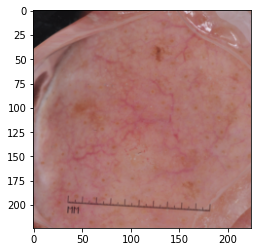

In [45]:
img_path = "/content/drive/MyDrive/Skin-classification/data/test/seborrheic_keratosis/ISIC_0012086.jpg"

print(mole_id(img_path))
#image = Image.open(img_path)
img = Image.open(img_path).convert('RGB')
transformations = transforms.Compose([transforms.Resize(size=224), transforms.CenterCrop((224,224))])
image = transformations(img)
plt.imshow(image)
plt.show()

In [46]:
testset = np.array(glob("/content/drive/MyDrive/Skin-classification/data/test/*/*"))

res = 0
x = 0
for x in range(len(testset)):
    
    if mole_id(testset[x]) == "Melanoma":
        res += 1
        
print(res)

0


In [48]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms

In [49]:
train_transfoms = transforms.Compose([transforms.Resize((299 , 299))
                              ,transforms.RandomRotation(degrees = 10)
                              ,transforms.RandomHorizontalFlip(p=0.2)
                              ,transforms.RandomGrayscale(p=0.2)
                              ,transforms.RandomVerticalFlip(p=0.2)
                              ,transforms.ToTensor()
                              ,transforms.Normalize(mean=[0.485, 0.456, 0.406]
                                                   , std=[0.229, 0.224, 0.225])
                              ])

test_val_transfomrs = transforms.Compose([transforms.Resize((299 , 299))
                              ,transforms.ToTensor()
                              ,transforms.Normalize(mean=[0.485, 0.456, 0.406]
                                                   , std = [0.229, 0.224, 0.225])
                              ])

batch_size = 4 #About all my little GPU can handle 
num_workers = 0

train_data = datasets.ImageFolder(root=r'/content/drive/MyDrive/Skin-classification/data/train'
                                  , transform=train_transfoms)
test_data = datasets.ImageFolder(root=r'/content/drive/MyDrive/Skin-classification/data/test'
                                 , transform=test_val_transfomrs)
valid_data = datasets.ImageFolder(root=r'/content/drive/MyDrive/Skin-classification/data/vaild'
                                  , transform=test_val_transfomrs)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders = dict(train=train_loader, test=test_loader, valid=valid_loader)


In [50]:
inception_net = models.inception_v3(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    inception_net = inception_net.cuda()

In [51]:
classifier = nn.Sequential(nn.Linear(2048, 512)
                           ,nn.ReLU()
                           #,nn.Dropout(0.1)
                           ,nn.Linear(512, 64)
                           ,nn.ReLU()
                           #,nn.Dropout(0.1)
                           ,nn.Linear(64, 3)
                          )
inception_net.fc = classifier

# Replace layer on aux outputs
aux_classifier = nn.Sequential(nn.Linear(768, 64)
                               ,nn.ReLU()
                               #,nn.Dropout(0.1)
                               ,nn.Linear(64, 3)
                              )
inception_net.AuxLogits.fc = aux_classifier 

# Transfer to GPU if available
if use_cuda:
    inception_net = inception_net.to('cuda')


In [52]:
inception_net.AuxLogits.fc, inception_net.fc

(Sequential(
   (0): Linear(in_features=768, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=3, bias=True)
 ), Sequential(
   (0): Linear(in_features=2048, out_features=512, bias=True)
   (1): ReLU()
   (2): Linear(in_features=512, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=3, bias=True)
 ))

In [53]:
criterion = nn.CrossEntropyLoss()
# These values were obtained from here https://arxiv.org/ftp/arxiv/papers/1810/1810.10348.pdf
optimizer = optim.SGD(inception_net.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

In [54]:
def label_accuracy(model, validation_loader, epoch, use_cuda):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in validation_loader:
            if use_cuda:
                images, targets = images.cuda(), targets.cuda()
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (preds == targets).sum().item()
    print('Accuray test at epoch {}\tLabel Accuracy : - {} %'.format(epoch, round(correct / total, 2)))

In [55]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the accumulated gradients 
            optimizer.zero_grad()
            
            # inception net produces two outputs, aux output handles vanishing gradient
            outputs, aux_outputs = model(data)
            #loss calculation https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
            loss1 = criterion(outputs, target)
            loss2 = criterion(aux_outputs, target)
            loss = loss1 + 0.4*loss2 # 0.4 is weight for auxillary classifier
            
            # gradient of the loss with respect to the parameters
            loss.backward()
            # perform the parameter update (update the weights)
            optimizer.step()
            
            ## record the average training loss
            # train loss - adds current loss to accumulated loss (averaged over batch size)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # get prediction
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            ## update the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path) #add save path here
            valid_loss_min = valid_loss
            # get epoch accuracy 
            #label_accuracy(model, loaders['valid'], epoch, use_cuda)
        
        # learning rate decay scheduled here if necessary
        #scheduler.step()
        
    return model

In [56]:
trained_model = train(50, loaders, inception_net, optimizer, criterion, use_cuda, save_path='/content/drive/MyDrive/Skin-classification/model_cancer_detection.pt')

Epoch: 1 	Training Loss: 1.513962 	Validation Loss: 1.089218
Validation loss decreased (inf --> 1.089218).  Saving model ...
Epoch: 2 	Training Loss: 1.532313 	Validation Loss: 1.096799
Epoch: 3 	Training Loss: 1.526272 	Validation Loss: 1.098225
Epoch: 4 	Training Loss: 1.512008 	Validation Loss: 1.098737
Epoch: 5 	Training Loss: 1.527593 	Validation Loss: 1.100735
Epoch: 6 	Training Loss: 1.513441 	Validation Loss: 1.099010
Epoch: 7 	Training Loss: 1.476145 	Validation Loss: 1.102120
Epoch: 8 	Training Loss: 1.512895 	Validation Loss: 1.098613
Epoch: 9 	Training Loss: 1.479991 	Validation Loss: 1.098904
Epoch: 10 	Training Loss: 1.503314 	Validation Loss: 1.100129
Epoch: 11 	Training Loss: 1.474460 	Validation Loss: 1.099609
Epoch: 12 	Training Loss: 1.470585 	Validation Loss: 1.098271
Epoch: 13 	Training Loss: 1.473969 	Validation Loss: 1.099883
Epoch: 14 	Training Loss: 1.440712 	Validation Loss: 1.099755
Epoch: 15 	Training Loss: 1.473976 	Validation Loss: 1.096809
Epoch: 16 	Trai

In [57]:
epoch = 50
label_accuracy(trained_model, loaders['valid'], epoch, use_cuda)

Accuray test at epoch 50	Label Accuracy : - 0.47 %
